<a href="https://colab.research.google.com/github/mukund2124/Stereo-Imaging-and-Depth-Analysis---THP/blob/main/Stereo_Imaging_and_Depth_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python opencv-contrib-python numpy matplotlib pillow requests

--2024-10-20 14:28:48--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeL.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315069 (308K) [image/jpeg]
Saving to: ‘left.jpg’

left.jpg            100%[===================>] 307.68K  --.-KB/s    in 0.04s   

2024-10-20 14:28:48 (8.11 MB/s) - ‘left.jpg’ saved [315069/315069]

--2024-10-20 14:28:48--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeR.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315113 (308K) [image/jpeg]
Saving t

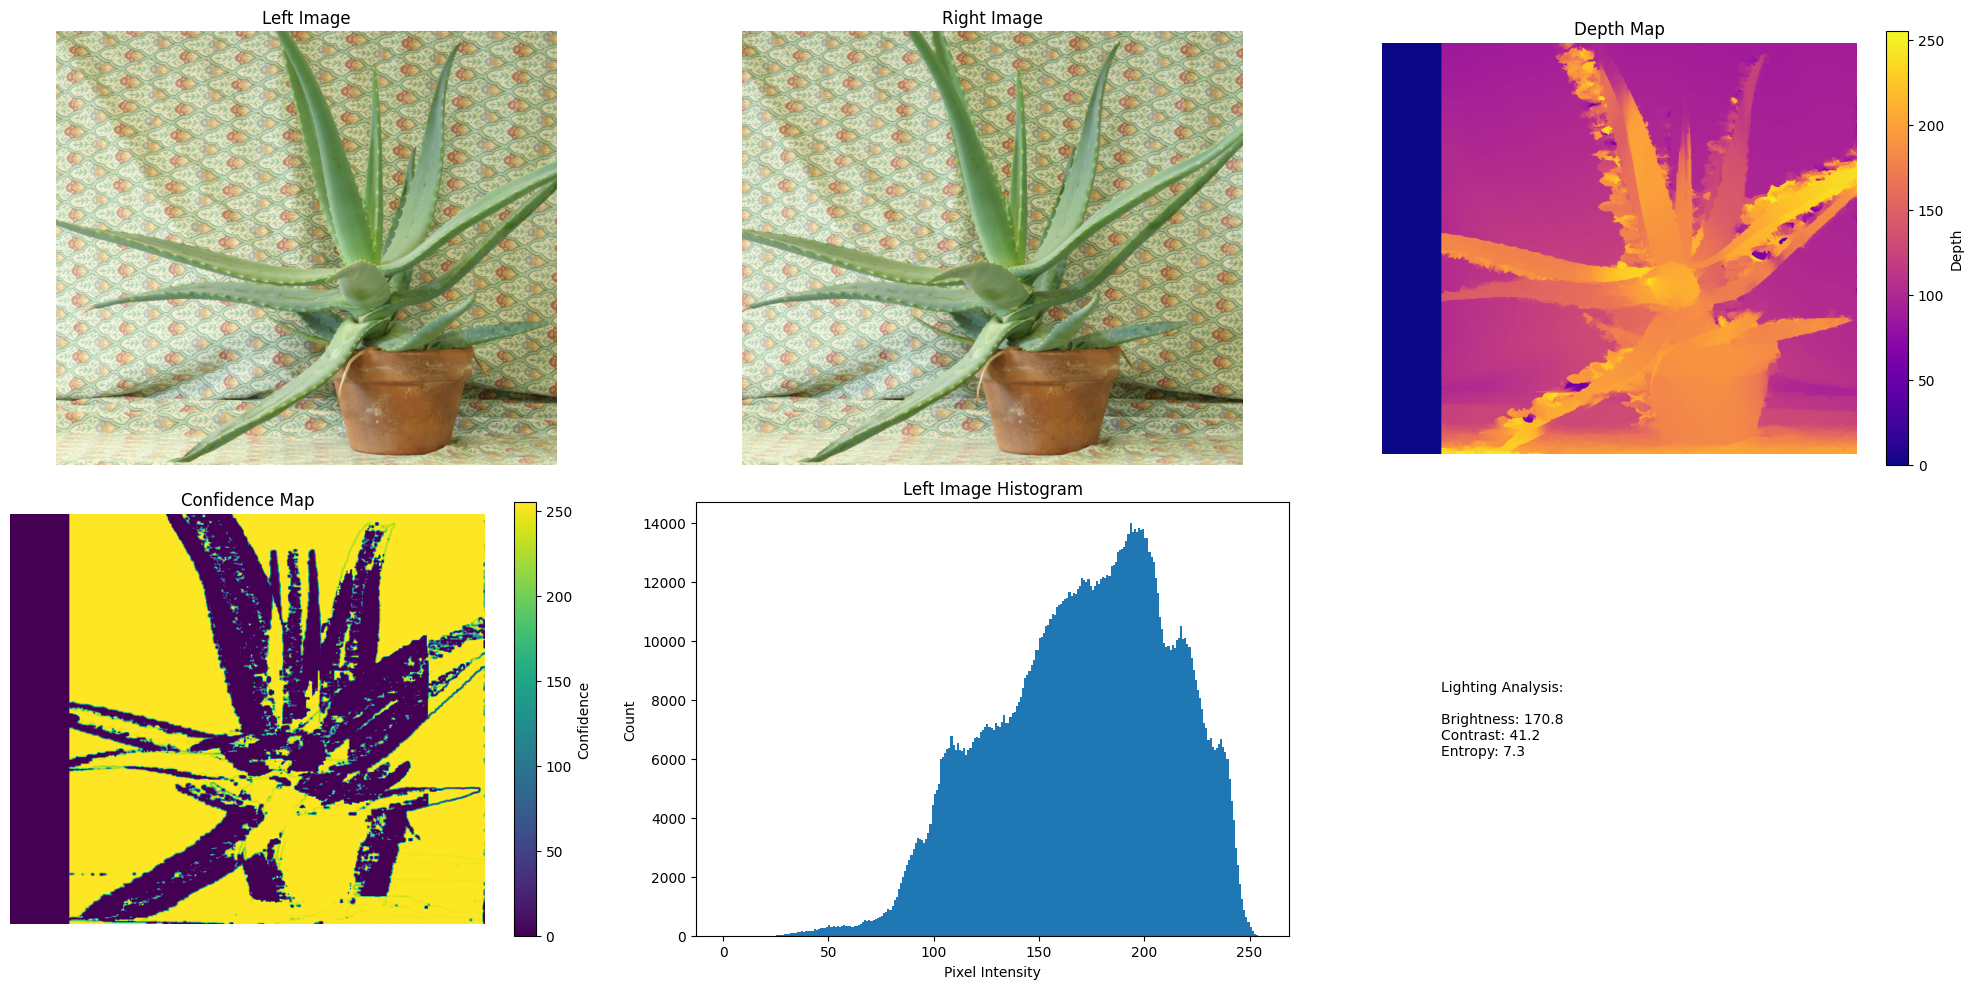

Processing complete!


In [7]:
# First, let's download some sample stereo images from a reliable source
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeL.jpg -O left.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeR.jpg -O right.jpg

import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import os

class StereoDepthEstimator:
    def __init__(self, window_size=5, min_disp=0, num_disp=160):
        self.window_size = window_size
        self.min_disp = min_disp
        self.num_disp = num_disp

        # Initialize stereo matcher
        self.left_matcher = cv2.StereoSGBM_create(
            minDisparity=self.min_disp,
            numDisparities=self.num_disp,
            blockSize=self.window_size,
            P1=8 * 3 * window_size ** 2,
            P2=32 * 3 * window_size ** 2,
            disp12MaxDiff=1,
            uniquenessRatio=15,
            speckleWindowSize=100,
            speckleRange=2,
            preFilterCap=63,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

        # Initialize right matcher
        self.right_matcher = cv2.ximgproc.createRightMatcher(self.left_matcher)

        # Initialize WLS filter
        self.wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=self.left_matcher)
        self.wls_filter.setLambda(8000)
        self.wls_filter.setSigmaColor(1.5)

    def load_images(self, left_path, right_path):
        """Load and verify images"""
        left_img = cv2.imread(left_path)
        right_img = cv2.imread(right_path)

        if left_img is None or right_img is None:
            raise ValueError("Failed to load images. Please check the file paths.")

        return left_img, right_img

    def preprocess_images(self, left_img, right_img):
        """Preprocess images"""
        def process_single_image(img):
            # Convert to grayscale if needed
            if len(img.shape) == 3:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img_gray = img

            # Apply bilateral filter
            img_filtered = cv2.bilateralFilter(img_gray, d=7, sigmaColor=25, sigmaSpace=25)

            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_eq = clahe.apply(img_filtered)

            return img_eq

        return process_single_image(left_img), process_single_image(right_img)

    def evaluate_lighting_conditions(self, image):
        """Analyze lighting conditions"""
        if image is None:
            raise ValueError("Invalid image input")

        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        brightness = np.mean(image)
        contrast = np.std(image)

        # Calculate histogram
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist_normalized = hist.ravel() / hist.sum()

        # Calculate entropy
        entropy = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-7))

        return {
            'brightness': brightness,
            'contrast': contrast,
            'entropy': entropy
        }

    def compute_depth_map(self, left_img, right_img):
        """Compute depth map"""
        # Compute disparities
        left_disp = self.left_matcher.compute(left_img, right_img).astype(np.float32)/16.0
        right_disp = self.right_matcher.compute(right_img, left_img).astype(np.float32)/16.0

        # Apply WLS filter
        filtered_disp = self.wls_filter.filter(left_disp, left_img, None, right_disp)

        # Compute confidence map
        conf_map = self.wls_filter.getConfidenceMap()

        # Normalize disparity map
        filtered_disp_vis = cv2.normalize(src=filtered_disp, dst=None, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)

        filtered_disp_vis = np.uint8(filtered_disp_vis)

        return filtered_disp_vis, conf_map

    def visualize_results(self, left_img, right_img, depth_map, conf_map, lighting_analysis, save=False):
        """Visualize results"""
        plt.figure(figsize=(20, 10))

        # Original images and depth map
        plt.subplot(231)
        plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        plt.title('Left Image')
        plt.axis('off')

        plt.subplot(232)
        plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
        plt.title('Right Image')
        plt.axis('off')

        plt.subplot(233)
        depth_plot = plt.imshow(depth_map, cmap='plasma')
        plt.title('Depth Map')
        plt.colorbar(depth_plot, label='Depth')
        plt.axis('off')

        # Confidence map
        plt.subplot(234)
        conf_plot = plt.imshow(conf_map, cmap='viridis')
        plt.title('Confidence Map')
        plt.colorbar(conf_plot, label='Confidence')
        plt.axis('off')

        # Lighting analysis plots
        plt.subplot(235)
        plt.hist(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).ravel(), 256, [0, 256])
        plt.title('Left Image Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Count')

        # Text summary
        plt.subplot(236)
        plt.axis('off')
        summary_text = (
            f"Lighting Analysis:\n\n"
            f"Brightness: {lighting_analysis['brightness']:.1f}\n"
            f"Contrast: {lighting_analysis['contrast']:.1f}\n"
            f"Entropy: {lighting_analysis['entropy']:.1f}"
        )
        plt.text(0.1, 0.5, summary_text, fontsize=10, va='center')

        plt.tight_layout()
        if save:
            plt.savefig('depth_analysis_results.png')
        plt.show()

def main():
    try:
        # Initialize depth estimator
        depth_estimator = StereoDepthEstimator()

        # Load images
        print("Loading images...")
        left_img, right_img = depth_estimator.load_images('left.jpg', 'right.jpg')
        print("Images loaded successfully!")

        # Analyze lighting conditions
        print("\nAnalyzing lighting conditions...")
        lighting_analysis = depth_estimator.evaluate_lighting_conditions(left_img)
        print("Lighting Analysis:")
        for key, value in lighting_analysis.items():
            print(f"{key}: {value:.2f}")

        # Preprocess images
        print("\nPreprocessing images...")
        left_proc, right_proc = depth_estimator.preprocess_images(left_img, right_img)

        # Compute depth map
        print("Computing depth map...")
        depth_map, conf_map = depth_estimator.compute_depth_map(left_proc, right_proc)

        # Visualize results
        print("\nGenerating visualizations...")
        depth_estimator.visualize_results(left_img, right_img, depth_map, conf_map,
                                        lighting_analysis, save=True)
        print("Processing complete!")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 10.4 MB/s eta 0:00:00
Testing depth estimation algorithm across multiple scenes...


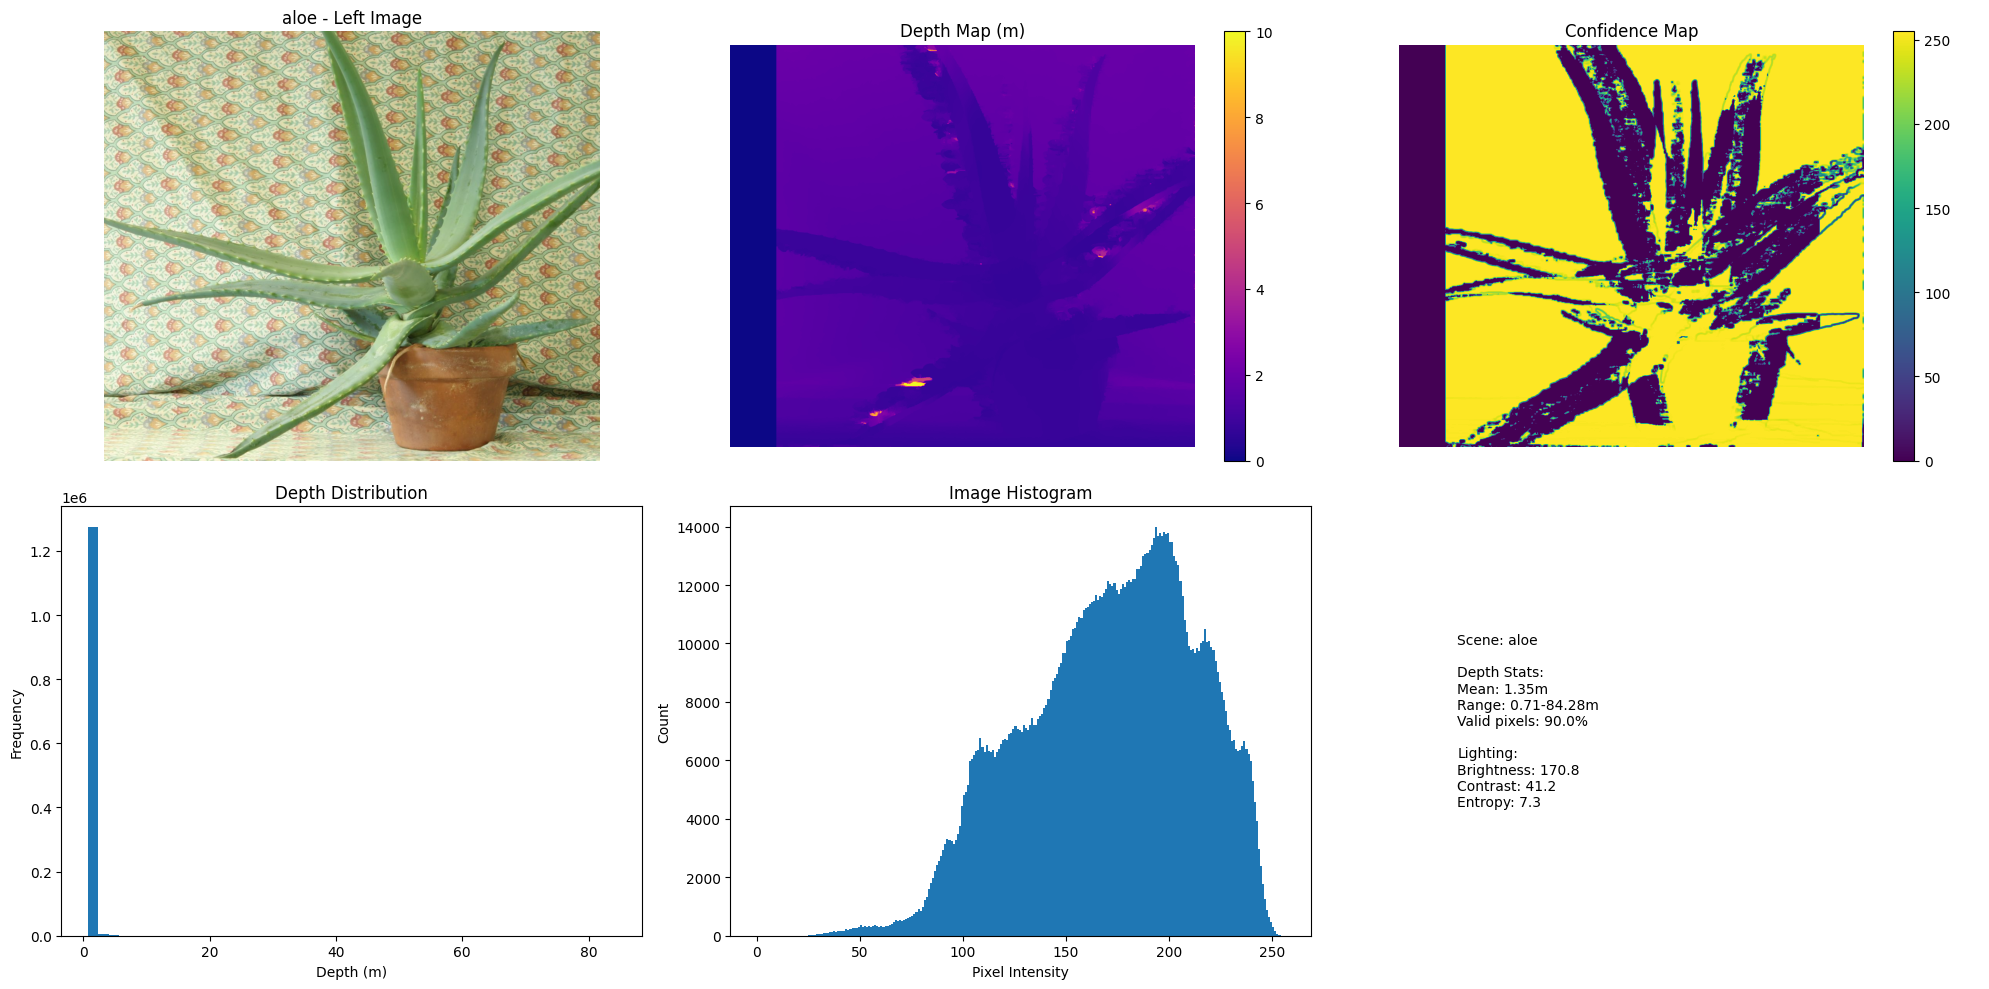

Failed to load images for scene tsukuba

Summary Statistics Across All Scenes:
       brightness   contrast   entropy  min_depth  max_depth  mean_depth  \
count    1.000000   1.000000  1.000000   1.000000   1.000000    1.000000   
mean   170.763401  41.167401  7.329898   0.706778  84.275116    1.345308   
std           NaN        NaN       NaN        NaN        NaN         NaN   
min    170.763401  41.167401  7.329898   0.706778  84.275116    1.345308   
25%    170.763401  41.167401  7.329898   0.706778  84.275116    1.345308   
50%    170.763401  41.167401  7.329898   0.706778  84.275116    1.345308   
75%    170.763401  41.167401  7.329898   0.706778  84.275116    1.345308   
max    170.763401  41.167401  7.329898   0.706778  84.275116    1.345308   

       std_depth  valid_pixel_ratio  mean_confidence  high_conf_ratio  
count   1.000000           1.000000         1.000000         1.000000  
mean    0.662218          90.015601       179.792297        73.734133  
std          NaN    

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import os
import pandas as pd
from datetime import datetime

class StereoDepthCalculator:
    def __init__(self, baseline=0.12, focal_length=3.6, sensor_width=6.17):
        """
        Initialize with camera parameters
        baseline: Distance between cameras (in meters)
        focal_length: Focal length of cameras (in mm)
        sensor_width: Width of camera sensor (in mm)
        """
        self.baseline = baseline  # meters
        self.focal_length = focal_length  # mm
        self.sensor_width = sensor_width  # mm

        # Initialize stereo matcher with parameters for accurate depth
        self.stereo = cv2.StereoSGBM_create(
            minDisparity=0,
            numDisparities=128,
            blockSize=5,
            P1=8 * 3 * 5 ** 2,
            P2=32 * 3 * 5 ** 2,
            disp12MaxDiff=1,
            uniquenessRatio=15,
            speckleWindowSize=100,
            speckleRange=2,
            preFilterCap=63,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

        # Initialize WLS filter for better disparity map
        self.right_matcher = cv2.ximgproc.createRightMatcher(self.stereo)
        self.wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=self.stereo)
        self.wls_filter.setLambda(8000)
        self.wls_filter.setSigmaColor(1.5)

    def calculate_depth(self, disparity, image_width):
        """
        Calculate depth from disparity
        Returns depth map in meters
        """
        # Convert disparity to meters
        # Depth = (baseline * focal_length * image_width) / (disparity * sensor_width)
        depth = np.zeros_like(disparity, dtype=np.float32)
        valid_disparity = disparity > 0
        depth[valid_disparity] = (self.baseline * self.focal_length * image_width) / (disparity[valid_disparity] * self.sensor_width)
        return depth

    def process_stereo_pair(self, left_img, right_img):
        """Process stereo pair and return depth map"""
        # Convert to grayscale if needed
        if len(left_img.shape) == 3:
            left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
            right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
        else:
            left_gray = left_img
            right_gray = right_img

        # Compute disparities
        left_disp = self.stereo.compute(left_gray, right_gray).astype(np.float32) / 16.0
        right_disp = self.right_matcher.compute(right_gray, left_gray).astype(np.float32) / 16.0

        # Apply WLS filter
        filtered_disp = self.wls_filter.filter(left_disp, left_gray, None, right_disp)

        # Calculate depth
        depth_map = self.calculate_depth(filtered_disp, left_img.shape[1])

        # Get confidence map
        conf_map = self.wls_filter.getConfidenceMap()

        return depth_map, conf_map, filtered_disp

    def analyze_lighting(self, image):
        """Analyze lighting conditions in image"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        brightness = np.mean(gray)
        contrast = np.std(gray)

        # Calculate histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist_normalized = hist.ravel() / hist.sum()
        entropy = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-7))

        return {
            'brightness': brightness,
            'contrast': contrast,
            'entropy': entropy
        }

    def evaluate_depth_map(self, depth_map, conf_map):
        """Evaluate depth map quality"""
        valid_depths = depth_map[depth_map > 0]
        valid_conf = conf_map[depth_map > 0]

        metrics = {
            'min_depth': np.min(valid_depths),
            'max_depth': np.max(valid_depths),
            'mean_depth': np.mean(valid_depths),
            'std_depth': np.std(valid_depths),
            'valid_pixel_ratio': len(valid_depths) / depth_map.size * 100,
            'mean_confidence': np.mean(valid_conf),
            'high_conf_ratio': np.sum(valid_conf > 0.7) / len(valid_conf) * 100
        }
        return metrics

def test_multiple_scenes():
    """Test algorithm on multiple scenes and generate comprehensive report"""
    # Download test images
    test_scenes = [
        ('https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeL.jpg',
         'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeR.jpg',
         'aloe'),
        ('https://raw.githubusercontent.com/opencv/opencv/master/samples/data/tsukubaL.png',
         'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/tsukubaR.png',
         'tsukuba')
    ]

    results = []
    calculator = StereoDepthCalculator()

    for left_url, right_url, scene_name in test_scenes:
        try:
            # Download images
            !wget -q {left_url} -O {scene_name}_left.jpg
            !wget -q {right_url} -O {scene_name}_right.jpg

            # Load images
            left_img = cv2.imread(f'{scene_name}_left.jpg')
            right_img = cv2.imread(f'{scene_name}_right.jpg')

            if left_img is None or right_img is None:
                print(f"Failed to load images for scene {scene_name}")
                continue

            # Process images
            depth_map, conf_map, disparity = calculator.process_stereo_pair(left_img, right_img)

            # Analyze results
            lighting = calculator.analyze_lighting(left_img)
            depth_metrics = calculator.evaluate_depth_map(depth_map, conf_map)

            # Store results
            results.append({
                'scene': scene_name,
                **lighting,
                **depth_metrics
            })

            # Visualize results
            plt.figure(figsize=(20, 10))

            plt.subplot(231)
            plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
            plt.title(f'{scene_name} - Left Image')
            plt.axis('off')

            plt.subplot(232)
            depth_vis = np.clip(depth_map, 0, 10)  # Clip to 10m for visualization
            plt.imshow(depth_vis, cmap='plasma')
            plt.title('Depth Map (m)')
            plt.colorbar()
            plt.axis('off')

            plt.subplot(233)
            plt.imshow(conf_map, cmap='viridis')
            plt.title('Confidence Map')
            plt.colorbar()
            plt.axis('off')

            plt.subplot(234)
            plt.hist(depth_map[depth_map > 0].ravel(), bins=50)
            plt.title('Depth Distribution')
            plt.xlabel('Depth (m)')
            plt.ylabel('Frequency')

            plt.subplot(235)
            plt.hist(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).ravel(), 256, [0, 256])
            plt.title('Image Histogram')
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Count')

            # Text summary
            plt.subplot(236)
            plt.axis('off')
            summary = (
                f"Scene: {scene_name}\n\n"
                f"Depth Stats:\n"
                f"Mean: {depth_metrics['mean_depth']:.2f}m\n"
                f"Range: {depth_metrics['min_depth']:.2f}-{depth_metrics['max_depth']:.2f}m\n"
                f"Valid pixels: {depth_metrics['valid_pixel_ratio']:.1f}%\n\n"
                f"Lighting:\n"
                f"Brightness: {lighting['brightness']:.1f}\n"
                f"Contrast: {lighting['contrast']:.1f}\n"
                f"Entropy: {lighting['entropy']:.1f}"
            )
            plt.text(0.1, 0.5, summary, fontsize=10, va='center')

            plt.tight_layout()
            plt.savefig(f'{scene_name}_analysis.png')
            plt.show()

        except Exception as e:
            print(f"Error processing scene {scene_name}: {str(e)}")

    # Generate summary report
    if results:
        df = pd.DataFrame(results)
        print("\nSummary Statistics Across All Scenes:")
        print(df.describe())

        # Save results
        df.to_csv('depth_analysis_results.csv', index=False)
        print("\nDetailed results saved to 'depth_analysis_results.csv'")

if __name__ == "__main__":
    # Install required packages
    !pip install -q opencv-python-headless opencv-contrib-python-headless numpy pandas matplotlib

    print("Testing depth estimation algorithm across multiple scenes...")
    test_multiple_scenes()

In [20]:
# Load the left and right images
left_image = cv2.imread('/content/aloe_left.jpg', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('/content/aloe_right.jpg', cv2.IMREAD_GRAYSCALE)

Image dimensions: 1282x1110


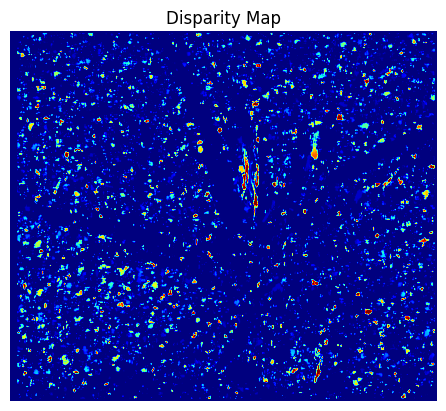

In [21]:
# Verify the dimensions of the images
height, width = left_image.shape
print(f"Image dimensions: {width}x{height}")

# Choose blockSize within the appropriate range and not larger than image dimensions
block_size = 15  # Must be an odd number between 5 and 255, less than width and height of the images

# Check if the blockSize is larger than the image dimensions, if so, adjust it
if block_size >= width or block_size >= height:
    block_size = min(width, height) - 1  # Ensure it's smaller than the dimensions
    if block_size % 2 == 0:
        block_size -= 1  # Make it odd

# Create StereoBM object with the adjusted blockSize
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=block_size)

# Compute disparity map
disparity = stereo.compute(left_image, right_image)

# Normalize the disparity map for visualization
disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Display the disparity map
plt.imshow(disparity_normalized, cmap='jet')
plt.title('Disparity Map')
plt.axis('off')
plt.show()


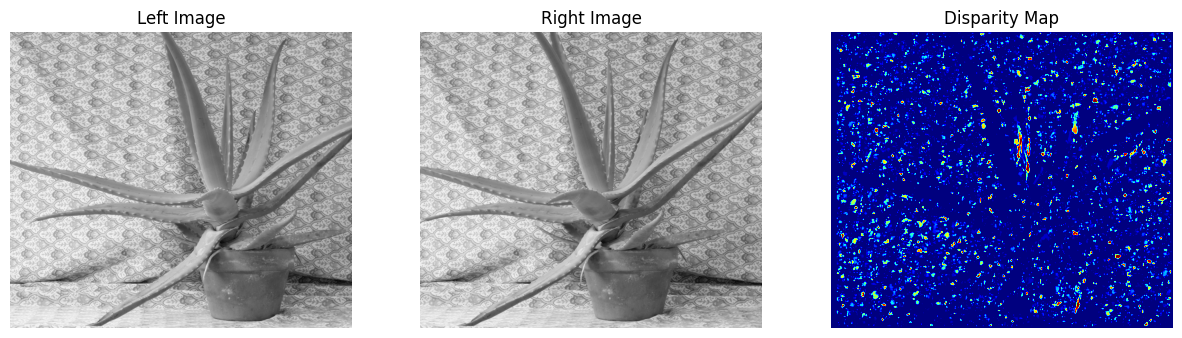

In [22]:
# Normalize the disparity map
disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Plot the images and disparity map
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(left_image, cmap='gray')
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(right_image, cmap='gray')
plt.title('Right Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(disparity_normalized, cmap='jet')
plt.title('Disparity Map')
plt.axis('off')

plt.show()


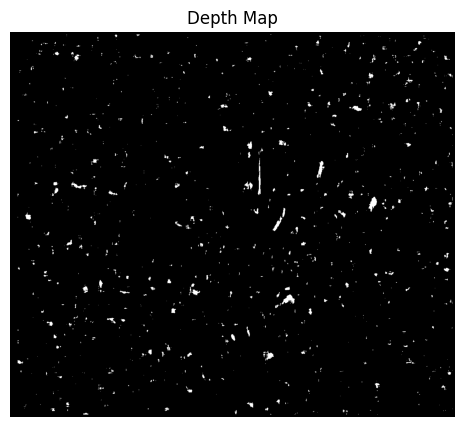

In [23]:
# Define focal length and baseline (in pixels)
focal_length = 700  # Example value
baseline = 0.1      # Example value in meters

# Calculate depth map
depth_map = (focal_length * baseline) / (disparity + 1e-6)  # Adding a small value to avoid division by zero
depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Plot the depth map
plt.figure(figsize=(8, 5))
plt.imshow(depth_map_normalized, cmap='gray')
plt.title('Depth Map')
plt.axis('off')
plt.show()
